Construct an emulator for $P(k)$ where we only consider one of the HOD parameters --- $\alpha$! 

In [1]:
import numpy as np 
import george as George
# -- local -- 
import env
import lhd as LHD
import data as Data
import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

1-dimensional Latin Hypercube Design

In [3]:
# 1D Latin Hypercube Design
lhd_1d = LHD.LHD(1, samples=17, method='mdu')
print lhd_1d.flatten()

[ 0.72501078  0.10174154  0.2727975   0.16983604  0.43954205  0.94821143
  0.63019087  0.22122265  0.38595748  0.57476278  0.32316445  0.50133723
  0.78985535  0.82502465  0.8886995   0.00184878  0.68449473]


HOD parameters where $log M_\mathrm{min}, \sigma_{\log M}, \log\,M_0$, and $\log M_1$ are fiducial values and $\alpha$ is selected by the LHD

In [4]:
thetas = np.zeros((len(lhd_1d), 5))
thetas[:,0] = 11.60 # log M_min
thetas[:,1] = 0.26  # sigma_logM
thetas[:,2] = 11.49 # log M0
thetas[:,3] = 12.83 # log M1
thetas[:,4] = 0.5 + lhd_1d.flatten() # alpha sampled by LHD 

Now lets generate $P_0(k)$ for these $\theta$s by first forward modeling the galaxy catalog $F(\theta)$ and measuring $P_0(k)$ from it

In [5]:
# halo catalog 
halos = Data.NeutHalos(0.0, 1, 4)

In [6]:
def BigF(theta, halos): 
    # F(theta) --- i.e. the galaxy catalog generated
    # from the halo catalog
    p_hod = {'logMmin': theta[0], 'sigma_logM': theta[1], 'logM0': theta[2], 'logM1': theta[3], 'alpha': theta[4]}
    g = FM.Galaxies(halos, p_hod, seed=seed)
    g['RSDPosition'] = FM.RSD(g, LOS=[0,0,1]) # impose RSD
    return g

def ObvsBigF(bigf, obvs='p0k'):
    # measure P(k) from F(theta)
    plk = FM.Observables(bigf, observable='plk', rsd=True, Nmesh=180)
    if obvs == 'p0k': 
        return plk['k'], plk['p0k']

In [7]:
seed = 1
p0k_lhd = []
for i in range(thetas.shape[0]): 
    gals_i = BigF(thetas[i,:], halos)
    kk, p0k_i = ObvsBigF(gals_i, obvs='p0k')
    p0k_lhd.append(p0k_i)
    if i == 0: karr = kk
p0k_lhd = np.array(p0k_lhd)

In [8]:
p0k_test = []
for i in range(10): 
    tt = thetas[0,:]
    tt[4] = 0.6+0.08*i
    gals_i = BigF(tt, halos)
    _, p0k_i = ObvsBigF(gals_i, obvs='p0k')
    p0k_test.append(p0k_i)
    if i == 0: karr = kk
p0k_test = np.array(p0k_test)

Lets see what the $P_0(k)$s look like sorted in ascending order of $\alpha$

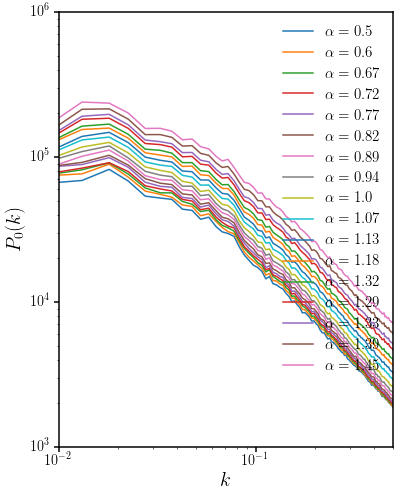

In [10]:
isort = np.argsort(lhd_1d.flatten())

fig = plt.figure(figsize=(6, 8))
sub = fig.add_subplot(111)
for i in isort:
    sub.plot(karr, p0k_lhd[i,:], label=r"$\alpha = "+str(round(thetas[i,4],2))+"$")
sub.legend(loc='upper right', prop={'size': 15}) 
# x-axis
sub.set_xscale('log')
sub.set_xlim([0.01, 0.5])
sub.set_xlabel('$k$', fontsize=20)
# y-axis
sub.set_yscale('log')
sub.set_ylim([1e3, 1e6])
sub.set_ylabel('$P_0(k)$', fontsize=20)

Pretty straightforward monotonic relations with $\alpha$, lets see how well we can emulate $P_0$ with a GP emulator

In [11]:
def trainGP(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    # note X is 1 dimensional
    lguess =  (np.max(X) - np.min(X))/float(len(X))

    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess)#, ndim=Y.shape[1])
        gp = George.GP(kernel, mean=np.average(Y[:,i]))
        gp.compute(X)
        gps.append(gp)
    return gps

In [12]:
import scipy.optimize as op
def nll(p, gp, Y):
    gp.set_parameter_vector(p)
    ll = gp.lnlikelihood(Y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

def grad_nll(p, gp, Y): 
    gp.set_parameter_vector(p)
    return -gp.grad_lnlikelihood(Y, quiet=True)

def trainGP_opt(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    # note X is 1 dimensional
    lguess =  (np.max(X) - np.min(X))/float(len(X))

    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess)#, ndim=Y.shape[1])
        gp = George.GP(kernel, mean=np.average(Y[:,i]))
        gp.compute(X)
        
        # optimize hyperparameters
        p0 = gp.get_parameter_vector()
        results = op.minimize(nll, p0, args=(gp, Y[:,i]), jac=grad_nll, method='L-BFGS-B')
        gp.set_parameter_vector(results.x)
        
        gps.append(gp)
    return gps

In [13]:
def emu(x_pred, gps, Y): 
    # use GPs to predict Plk at x_pred
    mus, vs = np.zeros(len(gps)), np.zeros(len(gps))
    for i, gp in enumerate(gps): 
        mu, var = gp.predict(Y[:,i], x_pred)
        mus[i] = mu
        vs[i] = var
    return mus, vs

In [83]:
from sklearn.decomposition import PCA

pca = PCA(whiten=True, svd_solver='full')
X_pca_lhd = pca.fit_transform(p0k_lhd)

In [88]:
print X_pca_lhd.shape
print pca.components_.shape
print pca.n_features_
print pca.n_samples_
print pca.explained_variance_ratio_

(17, 17)
(17, 112)
112
17
[  9.98011639e-01   1.32917402e-03   4.42380870e-04   7.68326914e-05
   6.76099467e-05   2.36513495e-05   1.63325209e-05   1.14677962e-05
   5.98924869e-06   5.11692970e-06   2.93322760e-06   2.33074303e-06
   1.83515513e-06   1.37243738e-06   8.29356358e-07   5.04468594e-07
   4.01741619e-32]


(0.5, 1.5)

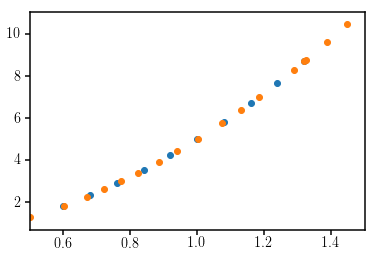

In [101]:
def f(x): 
    return 5*x**2

gp_emu = trainGP(thetas[:,4], np.reshape(f(thetas[:,4]),(-1,1)))

fig = plt.figure()
sub = fig.add_subplot(111)

xpred, fxs = [], []
for i in range(10): 
    alph = 0.6+0.08*i
    fx,_ = gp_emu[0].predict(f(thetas[:,4]), alph)#emu(alph, gp_emu, f(thetas[:,4]))
    fxs.append(fx)
    xpred.append(alph)

sub.scatter(xpred, np.array(fxs).flatten())
sub.scatter(thetas[:,4], f(thetas[:,4]))
sub.set_xlim([0.5, 1.5])

Lets compare the residual between $P_0^{GP}(k|\theta)$ versus $P_0(k|\theta)$

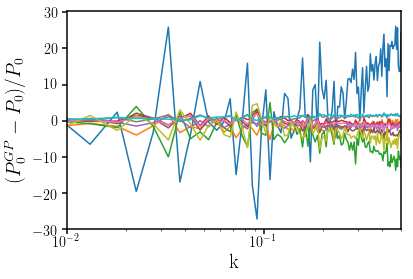

In [78]:
gp_emu = trainGP(thetas[:,4], X_pca_lhd)

fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(10): 
    alph = 0.6+0.08*i
    X_pca_gp,_ = emu(alph, gp_emu, X_pca_lhd)
    p0k_gp = pca.inverse_transform(X_pca_gp)
    p0k_i = p0k_test[i,:]
    sub.plot(karr, (p0k_gp - p0k_i)/p0k_i)
sub.set_xlabel('k', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')
sub.set_ylabel('$(P_0^{GP} - P_0)/P_0$', fontsize=20)

In [72]:
gp_emu_opt = trainGP_opt(thetas[:,4], X_pca_lhd)

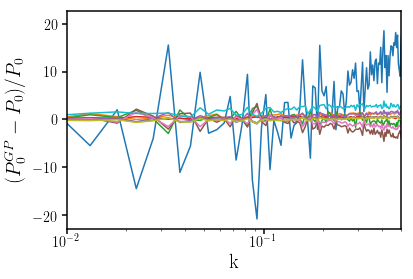

In [70]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(10): 
    alph = 0.6+0.08*i
    X_pca_gp, _ = emu(alph, gp_emu_opt, pca_components)
    p0k_gp = pca.inverse_transform(X_pca_gp)
    p0k_i = p0k_test[i,:]
    sub.plot(karr, (p0k_gp - p0k_i)/p0k_i)
sub.set_xlabel('k', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')
sub.set_ylabel('$(P_0^{GP} - P_0)/P_0$', fontsize=20)
